# Image Classification with DNN

## DATASETS:
(a) Carbonic Anhydrase II (ChEMBL205), a protein lyase,  
(b) Cyclin-dependent kinase 2 (CHEMBL301), a protein kinase,  
(c) ether-a-go-go-related gene potassium channel 1 (HERG) (CHEMBL240), a voltage-gated ion channel,  
(d) Dopamine D4 receptor (CHEMBL219), a monoamine GPCR,  
(e) Coagulation factor X (CHEMBL244), a serine protease,  
(f) Cannabinoid CB1 receptor (CHEMBL218), a lipid-like GPCR and  
(g) Cytochrome P450 19A1 (CHEMBL1978), a cytochrome P450.  
The activity classes were selected based on data availability and as representatives of therapeutically important target classes or as anti-targets.

In [1]:
!nvidia-smi

Fri Apr 29 11:33:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   34C    P0    40W / 300W |    105MiB / 32505MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [11:33:27] Enabling RDKit 2019.09.3 jupyter extensions
[11:33:27] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
dataset = 'CHEMBL205'

In [6]:
path = Path('../dataset/13321_2017_226_MOESM1_ESM/')
df = pd.read_csv(path/f'{dataset}/{dataset}_cl.csv')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/13321_2017_226_MOESM1_ESM/mol_images'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL218'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL219'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL240'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL244'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL301'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL205'),
 PosixPath('../dataset/13321_2017_226_MOESM1_ESM/CHEMBL1978')]

In [8]:
DATA = path/'mol_images'

In [9]:
IMAGES = DATA/dataset

# Load DF

In [10]:
df = pd.read_csv(path/f'{dataset}/{dataset}_train_valid.csv')
df.head()

,CID,SMILES,Activity,is_valid
0,CHEMBL1589687,S1c2n(ncn2)C(O)=C1C([NH+]1CCc2c(C1)cccc2)c1ccc...,0,False
1,CHEMBL3092937,S(=O)(=O)(N)c1cc(ccc1)-c1nnn(c1)C1OC(COC(=O)C)...,1,False
2,CHEMBL325684,O=C1N(Cc2ccc(cc2)-c2ccccc2C(=O)[O-])C(=NC12CC2...,0,False
3,CHEMBL488713,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1N=CCC1C(=O)Nc...,0,False
4,CHEMBL2069846,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1CCN(CC1)C(=O)...,0,False


In [11]:
df_test = pd.read_csv(path/f'{dataset}/{dataset}_test1.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       3589 non-null   object
 1   SMILES    3589 non-null   object
 2   Activity  3589 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 84.2+ KB


In [12]:
df_test.head()

,CID,SMILES,Activity
0,CHEMBL1272094,S(=O)(=O)(C)c1cc2[nH]c(nc2cc1)-c1ncc(cc1)-c1cc...,0
1,CHEMBL1929412,[NH+]1(CCCCC1)Cc1ccc(NCc2nc3c(nc2N)cccc3)cc1,0
2,CHEMBL3104775,FC(F)(F)c1cc(cc(c1)C(F)(F)F)C(C(=O)NC(C(=O)NCC...,0
3,CHEMBL1774231,FC(F)(F)c1cc(OC)c(cc1)C1CC[NH+](CC1C)Cc1nc2ncc...,0
4,CHEMBL426803,S(=O)(=O)(N)c1ccc(N/C(/S)=N/C(CC(C)C)C(OCC(=O)...,1


# Create dataloader

In [13]:
from fastai.vision.all import *

In [14]:
df['Image'] = df['CID'] + '.png'
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL1589687,S1c2n(ncn2)C(O)=C1C([NH+]1CCc2c(C1)cccc2)c1ccc(F)cc1,0,False,CHEMBL1589687.png
1,CHEMBL3092937,S(=O)(=O)(N)c1cc(ccc1)-c1nnn(c1)C1OC(COC(=O)C)C(OC(=O)C)C(OC(=O)C)C1OC(=O)C,1,False,CHEMBL3092937.png
2,CHEMBL325684,O=C1N(Cc2ccc(cc2)-c2ccccc2C(=O)[O-])C(=NC12CC2)CCCC,0,False,CHEMBL325684.png
3,CHEMBL488713,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1N=CCC1C(=O)Nc1ccccc1OCC(=O)[O-],0,False,CHEMBL488713.png
4,CHEMBL2069846,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1CCN(CC1)C(=O)c1ccc(N2CC[NH+](CC2)C)cc1,0,False,CHEMBL2069846.png


In [15]:
images = df['CID'] + ".png"
images.head()

0    CHEMBL1589687.png
1    CHEMBL3092937.png
2     CHEMBL325684.png
3     CHEMBL488713.png
4    CHEMBL2069846.png
Name: CID, dtype: object

In [16]:
# No flips, some rotation and zoom. Normalize to imagenet_stats as
# we're using pretrained models.
batch_tfms = [*aug_transforms(mult=1.0, do_flip=False, flip_vert=False, 
               max_rotate=20.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0., 
               max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=None, 
               size=224, mode='bilinear', 
               pad_mode='border', align_corners=True, 
               batch=False, min_scale=1.0), 
              Normalize.from_stats(*imagenet_stats)]

In [17]:
db = DataBlock(
    blocks = (ImageBlock(), CategoryBlock()), 
    get_x=ColReader('Image', pref=IMAGES),
    get_y=ColReader('Activity'), 
    splitter=ColSplitter('is_valid'),
    item_tfms=None, 
    batch_tfms=batch_tfms,
    )

In [18]:
def get_df(dataset, test=False):
    if test:
        df = pd.read_csv(path/f'{dataset}/{dataset}_test1.csv')
    else:
        df = pd.read_csv(path/f'{dataset}/{dataset}_train_valid.csv')
    df['Image'] = df['CID'] + '.png'
    return df

In [19]:
def get_df_with_clusters(dataset, n_clusters=100, random_state=42, test_size=0.2):
    df = pd.read_csv(path/f'{dataset}/{dataset}_cl_ECFP_1024_with_{n_clusters}_clusters.csv')
    values = df.Cluster.value_counts(ascending=True)
    values = values[values < 2].index
    for i in list(values):
        df = df.drop(df[df.Cluster == i].index)
    df.reset_index(drop=True, inplace=True)
    x_train, x_valid = train_test_split(df.index, test_size=test_size, random_state=random_state, stratify=df['Cluster'])
    df.loc[x_train, 'is_valid']=False
    df.loc[x_valid, 'is_valid']=True
    df['Image'] = df['Name'] + '.png'
    return df

In [20]:
df = get_df(dataset)
df.head()

,CID,SMILES,Activity,is_valid,Image
0,CHEMBL1589687,S1c2n(ncn2)C(O)=C1C([NH+]1CCc2c(C1)cccc2)c1ccc(F)cc1,0,False,CHEMBL1589687.png
1,CHEMBL3092937,S(=O)(=O)(N)c1cc(ccc1)-c1nnn(c1)C1OC(COC(=O)C)C(OC(=O)C)C(OC(=O)C)C1OC(=O)C,1,False,CHEMBL3092937.png
2,CHEMBL325684,O=C1N(Cc2ccc(cc2)-c2ccccc2C(=O)[O-])C(=NC12CC2)CCCC,0,False,CHEMBL325684.png
3,CHEMBL488713,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1N=CCC1C(=O)Nc1ccccc1OCC(=O)[O-],0,False,CHEMBL488713.png
4,CHEMBL2069846,Fc1cc(F)c(F)cc1CC([NH3+])CC(=O)N1CCN(CC1)C(=O)c1ccc(N2CC[NH+](CC2)C)cc1,0,False,CHEMBL2069846.png


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10764 entries, 0 to 10763
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       10764 non-null  object
 1   SMILES    10764 non-null  object
 2   Activity  10764 non-null  int64 
 3   is_valid  10764 non-null  bool  
 4   Image     10764 non-null  object
dtypes: bool(1), int64(1), object(3)
memory usage: 347.0+ KB


In [22]:
df_test = get_df(dataset, test=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       3589 non-null   object
 1   SMILES    3589 non-null   object
 2   Activity  3589 non-null   int64 
 3   Image     3589 non-null   object
dtypes: int64(1), object(3)
memory usage: 112.3+ KB


In [23]:
df_test.head()

,CID,SMILES,Activity,Image
0,CHEMBL1272094,S(=O)(=O)(C)c1cc2[nH]c(nc2cc1)-c1ncc(cc1)-c1ccccc1F,0,CHEMBL1272094.png
1,CHEMBL1929412,[NH+]1(CCCCC1)Cc1ccc(NCc2nc3c(nc2N)cccc3)cc1,0,CHEMBL1929412.png
2,CHEMBL3104775,FC(F)(F)c1cc(cc(c1)C(F)(F)F)C(C(=O)NC(C(=O)NCC[NH3+])c1ccccc1)(C)C,0,CHEMBL3104775.png
3,CHEMBL1774231,FC(F)(F)c1cc(OC)c(cc1)C1CC[NH+](CC1C)Cc1nc2ncccc2n1C,0,CHEMBL1774231.png
4,CHEMBL426803,S(=O)(=O)(N)c1ccc(N/C(/S)=N/C(CC(C)C)C(OCC(=O)NC)=O)cc1,1,CHEMBL426803.png


In [24]:
IMAGES = DATA/dataset
IMAGES

Path('../dataset/13321_2017_226_MOESM1_ESM/mol_images/CHEMBL205')

In [25]:
def get_dls(dataset, bs=64, clustering=False, random_state=42, test=False):
    IMAGES = DATA/dataset
    if clustering:
        df = get_df_with_clusters(dataset, n_clusters=100)
    else:
        df = get_df(dataset, test=test)
    if test:
        db = DataBlock(
        blocks = (ImageBlock(), CategoryBlock()), 
        get_x=ColReader('Image', pref=IMAGES),
        get_y=ColReader('Activity'), 
        splitter=IndexSplitter([]),
        item_tfms=None, 
        batch_tfms=None,
        )
        dls = db.dataloaders(df, bs=32, shuffle_train=False)
    else:
        db = DataBlock(
            blocks = (ImageBlock(), CategoryBlock()), 
            get_x=ColReader('Image', pref=IMAGES),
            get_y=ColReader('Activity'), 
            splitter=ColSplitter('is_valid'),
            item_tfms=None, 
            batch_tfms=None,
            )
        dls = db.dataloaders(df, bs=bs, shuffle_train=True, random_state=42)
    return dls, df

In [26]:
dls, df = get_dls(dataset, clustering=False)

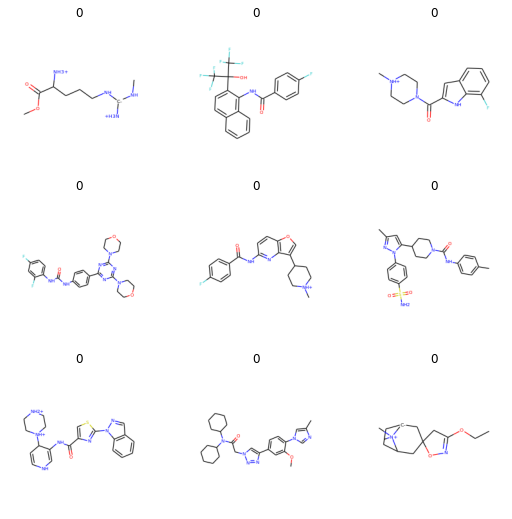

In [27]:
dls.show_batch()

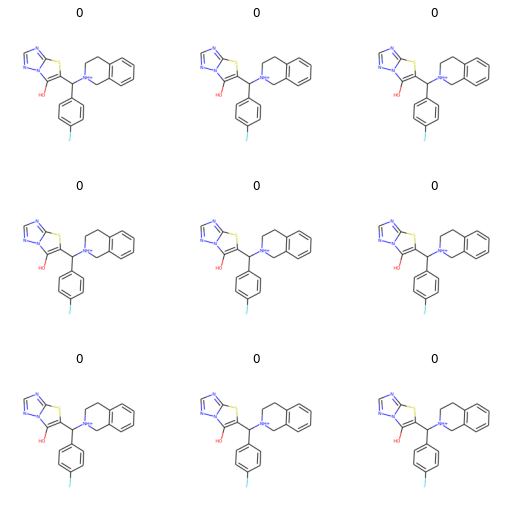

In [28]:
dls.show_batch(unique=True)

In [29]:
test_dls, test_df = get_dls(dataset, test=True)

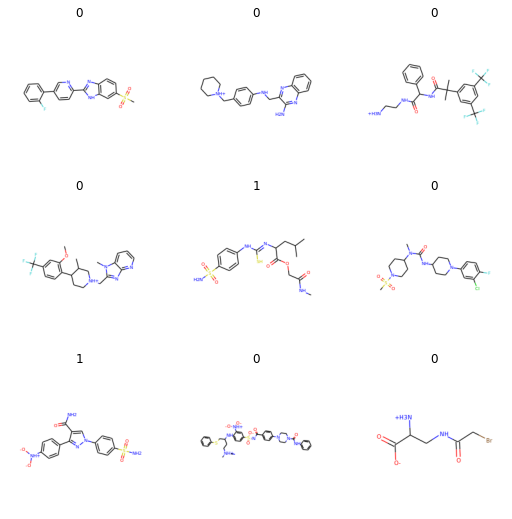

In [32]:
test_dls.show_batch()

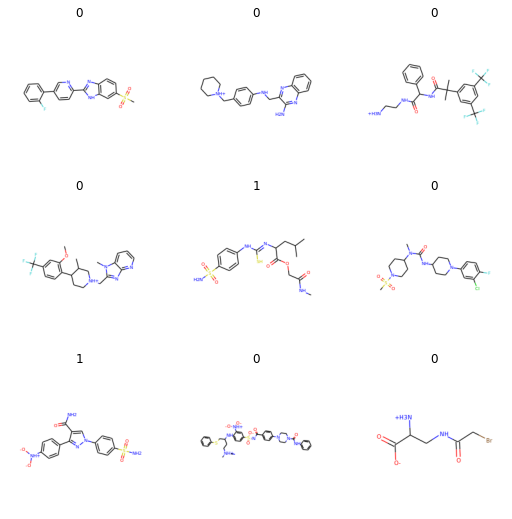

In [33]:
test_dls.show_batch()

In [46]:
tdf, y = test_dls.one_batch()
y[0:5]

TensorCategory([0, 0, 0, 0, 1], device='cuda:0')

# Create class weights

In [34]:
TARGET = 'Activity'

In [35]:
class_count_df = df.groupby(TARGET).count()
class_count_df

,CID,SMILES,is_valid,Image
Activity,,,,
0,9785,9785,9785,9785
1,979,979,979,979


In [36]:
n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]

In [37]:
w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
w_0, w_1

(0.5500255493101687, 5.4974463738508685)

In [38]:
class_weights=torch.FloatTensor([w_0, w_1]).cuda()

In [39]:
loss_func = CrossEntropyLossFlat(weight=class_weights)

In [40]:
def get_loss_func(df):
    TARGET = 'Activity'
    class_count_df = df.groupby(TARGET).count()
    n_0, n_1 = class_count_df.iloc[0, 0], class_count_df.iloc[1, 0]
    w_0 = (n_0 + n_1) / (2.0 * n_0)
    w_1 = (n_0 + n_1) / (2.0 * n_1)
    class_weights=torch.FloatTensor([w_0, w_1]).cuda()
    loss_func = CrossEntropyLossFlat(weight=class_weights)
    return loss_func

In [41]:
loss_func=get_loss_func(df)

# Train CNN model

In [42]:
from sklearn.metrics import auc,roc_auc_score,recall_score,precision_score,f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score

In [43]:
from fastai.callback.hook import *

In [44]:
def train_model(dls, arch=resnet18, loss_func=None, epochs=16, wd=None, lr=None):
    
    
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            loss_func=loss_func,
                            metrics=[accuracy, 
                            F1Score(), 
                            Precision(), 
                            Recall(), 
                            RocAucBinary(), 
                            MatthewsCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [78]:
# Train model on resnet18
learn = train_model(dls, loss_func=loss_func, epochs=5,lr=3e-3, wd=0.0002)

Architechture: <function resnet18 at 0x7fd4376eb710>
Trained epochs: epochs=5
Weight decay: wd=0.0002
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.638578,0.489158,0.753367,0.402700,0.258297,0.913265,0.899336,0.400596,00:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.285188,0.232088,0.909893,0.657244,0.502703,0.948980,0.969568,0.651916,00:18
1,0.250068,0.225523,0.948909,0.759825,0.664122,0.887755,0.971987,0.741559,00:18
2,0.167023,0.191871,0.959127,0.807018,0.707692,0.938776,0.977081,0.794466,00:18
3,0.082933,0.215226,0.958662,0.803532,0.708171,0.928571,0.975114,0.789857,00:17
4,0.036669,0.218241,0.961914,0.814480,0.731707,0.918367,0.976534,0.799923,00:18


In [79]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dls.train)

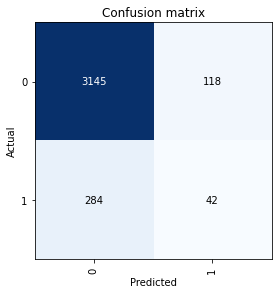

In [80]:
interp.plot_confusion_matrix()

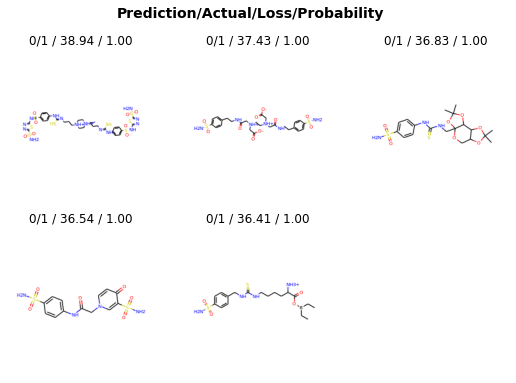

In [68]:
interp.plot_top_losses(k=5)

# Get the models output

In [66]:
def get_prediction_output(model, dl):
    predictions = pd.DataFrame()
    for inputs, y in dl:
        p = pd.DataFrame([])
        p['class'] = y.cpu().detach().numpy()
        preds = model.get_preds(inputs)
        p['predictions'] = list(preds.cpu().detach().numpy())
        predictions = pd.concat([predictions, p], ignore_index=True)
    return predictions

In [87]:
preds, y, y_pred = learn.get_preds(dl=test_dls.train, with_decoded=True)
preds[0:5], y[0:5], y_pred[0:5]

/home/mmiv-ml/anaconda3/envs/fastai-drug/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(tensor([[0.9955, 0.0045],
         [0.9973, 0.0027],
         [0.9892, 0.0108],
         [0.9956, 0.0044],
         [0.9957, 0.0043]]),
 TensorCategory([0, 0, 0, 0, 1]),
 tensor([0, 0, 0, 0, 0]),
 TensorBase([4.4675e-03, 2.7494e-03, 1.0844e-02, 4.3878e-03, 5.4467e+00]))

In [67]:
preds = get_prediction_output(learn, test_dls.train)

TypeError: only integer tensors of a single element can be converted to an index

In [68]:
preds.head()

NameError: name 'preds' is not defined

In [109]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3589 entries, 0 to 3588
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        3589 non-null   int64 
 1   predictions  3589 non-null   object
dtypes: int64(1), object(1)
memory usage: 56.2+ KB


In [110]:
preds.to_csv(path/f'{dataset}/{dataset}_predictions_CNN.csv', index=False)

# Test different regularizations

## Results:
### wd = 0.002 is good for around 15-20 epochs before overfitting
### lr = 3e-3 is good for most CNNs and also in this case
### dropout = 0.5 is a usually sustainable

In [ ]:
from sklearn.model_selection import ParameterGrid

In [ ]:
# wd = 0.002 works for around 15-20 epochs
# lr = 3e-3 is good most CNN and in this case
# dropout = 0.5 is a usually sustainable
# batch_size = 64
param_grid={
    "bs" : [128, 252, 512],
}
param_grid = ParameterGrid(param_grid)

for p in param_grid:
    dls = get_dls(dataset, bs=p['bs'])
    learn = train_model(dls, loss_func=loss_func, epochs=15, wd=0.002, lr=3e-3)

# Test random state

**Results:** Random state has a huge impact \
**Tip:** Try clustering methods

In [ ]:
random_states = [1,4,42,666]

In [ ]:
for r in random_states:
    dls = get_dls(dataset, df, random_state=r)
    learn = train_model(dls, epochs=10, lr=3e-3)

# Compare architechtures

**Results:** Not much difference between **Resnet18, Resnet34 and Resnet50** on (224, 224) size images. \
**Alexnet** got worse results then **resnet**. \
Reason could be that the extra layers is not much of a use in this case (i.e. The images does not contain a lot of details) \
**Resnet18** takes less time to train due to less layers and therefore should be used in this case. 

In [ ]:
archs =  [resnet18, resnet50, alexnet]

In [ ]:
for arch in archs:
    train_model(dls, arch=arch, epochs=15, lr=3e-3)

# Test clustering

In [ ]:
def train_on_dataset(learn = None, dataset, clustering = False):
    print(f'Training model on dataset: {dataset}')
    dls, df = get_dls(dataset, clustering=clustering)
    loss_func = get_loss_func(df)
    if learn == None:
        learn = train_model(dls, epochs = 10, lr=3e-3, loss_func=loss_func)
    else:
        learn = learn
        learn.dls = dls
        learn.fit()
    return learn

In [ ]:
learn = train_on_dataset(dataset, clustering=True)

In [ ]:
learn2 = train_on_dataset(dataset)

# Train on all datasets and store model

In [45]:
datasets = ['CHEMBL205',  'CHEMBL301',  
            'CHEMBL240', 'CHEMBL219', 
            'CHEMBL244', 'CHEMBL218',
           'CHEMBL1978',]

In [46]:
top_mcc_scores = {
    
    'CHEMBL205': 0.862,
    'CHEMBL301': 0.926,
    'CHEMBL240': 0.884,
    'CHEMBL219': 0.887,
    'CHEMBL244': 0.983,
    'CHEMBL218': 0.941,
    'CHEMBL1978': 0.904}

In [48]:
def train_on_dataset(dataset, learn=None, epochs=30, clustering = False):
    print(f'Training model on dataset: {dataset}')
    dls, df = get_dls(dataset, clustering=clustering)
    loss_func = get_loss_func(df)
    if learn == None:
        learn = train_model(dls, arch=resnet18, epochs = epochs, lr=None, loss_func=loss_func)
    else:
        learn = learn
        learn.dls = dls
        #lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        learn.fine_tune(epochs, 3e-3, wd=0.0002)
    return learn

In [ ]:
learn = train_on_dataset(datasets[0])
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=25)
learn.export(fname= f'models/{datasets[0]}')

Training model on dataset: CHEMBL205
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.010000000149011612


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.627050,0.602814,0.816105,0.460784,0.314031,0.865031,0.911434,0.448671,00:26


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.233832,0.141026,0.954862,0.786280,0.689815,0.914110,0.981835,0.771035,00:30
1,0.220475,0.333741,0.911117,0.663857,0.505618,0.966258,0.978788,0.661512,00:29
2,0.191716,0.117374,0.963778,0.817927,0.752577,0.895706,0.978845,0.801714,00:29
3,0.183360,0.148226,0.949847,0.763780,0.667431,0.892638,0.975479,0.746123,00:28
4,0.175710,0.212043,0.955977,0.743506,0.789655,0.702454,0.953921,0.720992,00:29
5,0.201727,0.238237,0.904430,0.647482,0.486862,0.966258,0.980328,0.646270,00:32
6,0.193635,0.227133,0.941767,0.713306,0.645161,0.797546,0.945726,0.686045,00:31
7,0.136931,0.111015,0.965729,0.827004,0.763636,0.901840,0.983426,0.811574,00:30
8,0.167639,0.112128,0.966286,0.831241,0.762148,0.914110,0.983819,0.816830,00:30
9,0.134330,0.147431,0.955977,0.789333,0.698113,0.907975,0.973486,0.773466,00:31


Training model on dataset: CHEMBL301
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.005754399299621582


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.833094,0.736782,0.729852,0.354391,0.226378,0.815603,0.843846,0.328868,00:15


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.420025,0.217201,0.914249,0.656331,0.516260,0.900709,0.969111,0.642396,00:17
1,0.183612,0.155965,0.947131,0.748466,0.659459,0.865248,0.975756,0.727817,00:16
2,0.111874,0.255903,0.952934,0.675556,0.904762,0.539007,0.954605,0.677428,00:16
3,0.200022,0.228961,0.929723,0.672673,0.583333,0.794326,0.954695,0.643833,00:16
4,0.201543,0.135314,0.961315,0.777778,0.813953,0.744681,0.959605,0.757535,00:17
5,0.152164,0.129851,0.963250,0.794224,0.808824,0.780142,0.976364,0.774206,00:18
6,0.129794,0.256314,0.952289,0.675439,0.885057,0.546099,0.931643,0.673416,00:19
7,0.130970,0.177399,0.957447,0.765957,0.765957,0.765957,0.955837,0.742553,00:18
8,0.162195,0.588390,0.785945,0.453947,0.295503,0.978723,0.960530,0.467121,00:18
9,0.108037,0.328989,0.941328,0.711111,0.643678,0.794326,0.944007,0.683509,00:17


Training model on dataset: CHEMBL240
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.004786301031708717


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.900222,0.726640,0.703896,0.331378,0.208487,0.807143,0.827020,0.301407,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.429166,0.272133,0.885714,0.576923,0.434783,0.857143,0.928015,0.558949,00:19
1,0.217330,0.197020,0.934416,0.693009,0.603175,0.814286,0.929337,0.666486,00:20
2,0.130266,0.192868,0.951948,0.713178,0.779661,0.657143,0.909658,0.690155,00:20
3,0.193814,0.250646,0.940260,0.570093,0.824324,0.435714,0.897949,0.573181,00:19
4,0.182386,0.286768,0.894805,0.595000,0.457692,0.850000,0.927949,0.575021,00:19
5,0.139530,0.245884,0.941558,0.671533,0.686567,0.657143,0.902138,0.639660,00:19
6,0.142960,0.284233,0.925325,0.646154,0.567568,0.750000,0.932709,0.612655,00:19
7,0.168842,0.261028,0.929221,0.603636,0.614815,0.592857,0.897827,0.564904,00:19
8,0.129511,0.129225,0.961039,0.763780,0.850877,0.692857,0.952250,0.747448,00:18
9,0.084207,0.151465,0.966883,0.821053,0.806897,0.835714,0.942816,0.802962,00:17


Training model on dataset: CHEMBL219
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.006918309628963471


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.768753,0.600425,0.793537,0.401042,0.272085,0.762376,0.849794,0.368722,00:12


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.376518,0.263076,0.899461,0.619048,0.471503,0.900990,0.963494,0.607169,00:12
1,0.213093,0.176977,0.944345,0.735043,0.646617,0.851485,0.947436,0.712933,00:13
2,0.141601,0.197908,0.942549,0.719298,0.645669,0.811881,0.949000,0.693362,00:13
3,0.157932,0.308672,0.933573,0.579545,0.680000,0.504950,0.900756,0.551449,00:12
4,0.171577,0.342055,0.888689,0.597403,0.444444,0.910891,0.949752,0.588620,00:13
5,0.176968,0.232748,0.938959,0.552632,0.823529,0.415842,0.938258,0.559065,00:13
6,0.151443,0.236719,0.919210,0.671533,0.531792,0.910891,0.958910,0.658737,00:13
7,0.142176,0.160071,0.947935,0.743363,0.672000,0.831683,0.973073,0.719786,00:15
8,0.121383,0.271322,0.935368,0.697479,0.605839,0.821782,0.954991,0.671874,00:16
9,0.138235,0.188324,0.943447,0.706977,0.666667,0.752475,0.952606,0.677324,00:16


Training model on dataset: CHEMBL244
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.006918309628963471


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.590761,0.882959,0.712753,0.371851,0.232104,0.934498,0.912202,0.373095,00:23


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.231562,0.093849,0.963846,0.816162,0.759398,0.882096,0.987575,0.798984,00:26
1,0.120693,0.146204,0.944378,0.758621,0.626781,0.960699,0.989606,0.750005,00:26
2,0.105806,0.145896,0.951927,0.772128,0.678808,0.895197,0.977106,0.754750,00:26
3,0.127774,0.071583,0.977751,0.873303,0.906103,0.842795,0.986720,0.861804,00:25
4,0.109675,0.277607,0.925705,0.702703,0.552500,0.965066,0.990465,0.697584,00:21
5,0.127275,0.946469,0.775526,0.438928,0.284062,0.965066,0.972724,0.449072,00:24
6,0.095730,0.130816,0.964640,0.766404,0.960526,0.637555,0.983061,0.766542,00:24
7,0.081276,0.078115,0.971395,0.856574,0.787546,0.938865,0.995328,0.844829,00:22
8,0.079135,0.074407,0.977751,0.871560,0.917874,0.829694,0.988077,0.860728,00:21
9,0.055814,0.127052,0.970600,0.810256,0.981366,0.689956,0.988131,0.809358,00:23


Training model on dataset: CHEMBL218
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.0007585775572806596


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.656594,0.585906,0.748148,0.393556,0.252212,0.895288,0.904683,0.386867,00:38


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.369996,0.366954,0.848507,0.526158,0.368201,0.921466,0.958738,0.523183,00:46
1,0.282093,0.276776,0.891039,0.605536,0.452196,0.916230,0.969939,0.596951,00:42
2,0.203652,0.173039,0.939307,0.731501,0.613475,0.905759,0.976202,0.715583,00:42
3,0.130558,0.140057,0.948148,0.754802,0.664016,0.874346,0.978976,0.735019,00:38
4,0.103458,0.137773,0.951732,0.770975,0.680000,0.890052,0.981690,0.752969,00:41
5,0.064786,0.109579,0.962724,0.801527,0.779703,0.824607,0.977245,0.781348,00:39
6,0.058866,0.138308,0.959140,0.798111,0.726882,0.884817,0.972134,0.780264,00:39
7,0.048591,0.141158,0.962963,0.805521,0.773494,0.840314,0.977651,0.785915,00:40
8,0.042325,0.186994,0.951493,0.768529,0.680808,0.882199,0.975173,0.749714,00:33
9,0.033139,0.136466,0.967742,0.826255,0.812658,0.840314,0.970513,0.808618,00:37


Training model on dataset: CHEMBL1978
Architechture: <function resnet18 at 0x7ff0923e2560>
Trained epochs: epochs=30
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.002290867641568184


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.818693,0.663574,0.733723,0.365854,0.233333,0.846774,0.882289,0.347885,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.405008,0.354792,0.863936,0.544118,0.390845,0.895161,0.949122,0.535161,00:20
1,0.250805,0.320316,0.882224,0.590331,0.431227,0.935484,0.964427,0.586862,00:21
2,0.182626,0.257153,0.915143,0.654762,0.518868,0.887097,0.966269,0.638710,00:22
3,0.129385,0.178908,0.946598,0.747405,0.654545,0.870968,0.957459,0.727385,00:20
4,0.094654,0.163897,0.954645,0.775362,0.703947,0.862903,0.964634,0.755239,00:21
5,0.163118,0.200534,0.940015,0.707143,0.634615,0.798387,0.960586,0.679729,00:21
6,0.132170,0.239622,0.938552,0.729032,0.607527,0.911290,0.969331,0.714152,00:21
7,0.092734,0.153874,0.964887,0.801653,0.822034,0.782258,0.962389,0.782694,00:21
8,0.102641,0.163995,0.964887,0.806452,0.806452,0.806452,0.969160,0.787143,00:18
9,0.098264,0.132859,0.956108,0.761905,0.750000,0.774194,0.973198,0.737850,00:21


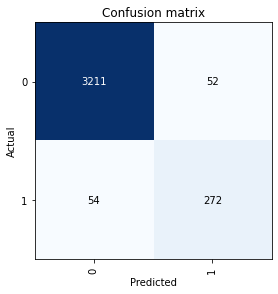

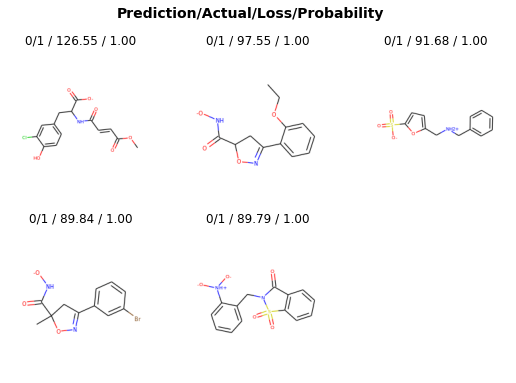

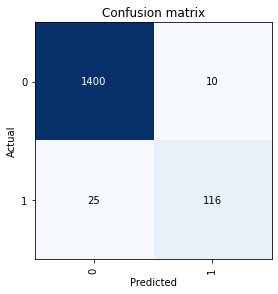

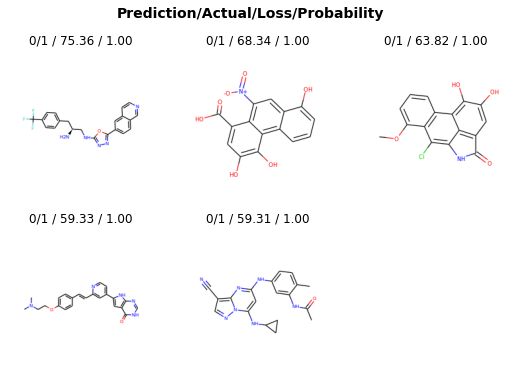

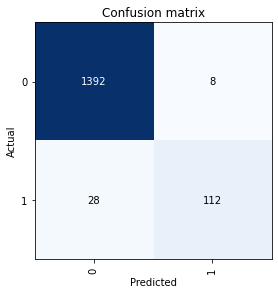

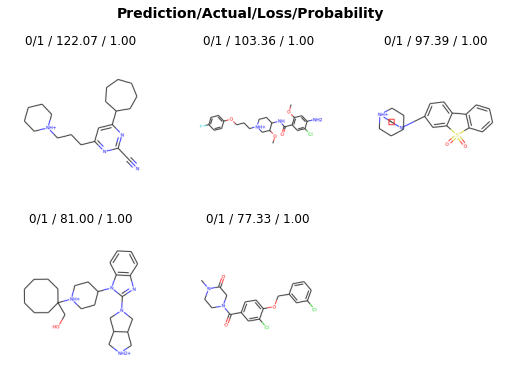

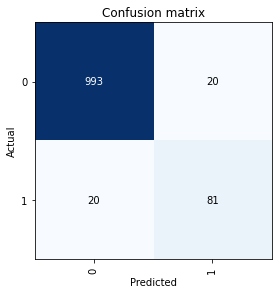

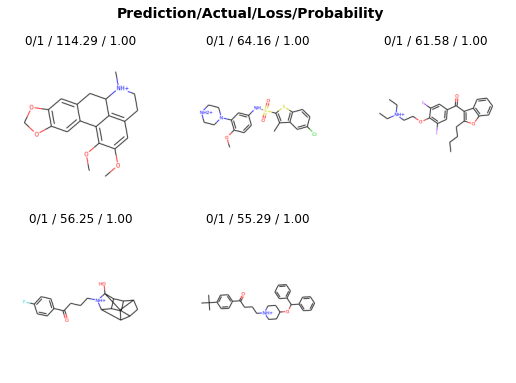

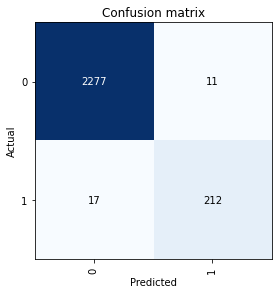

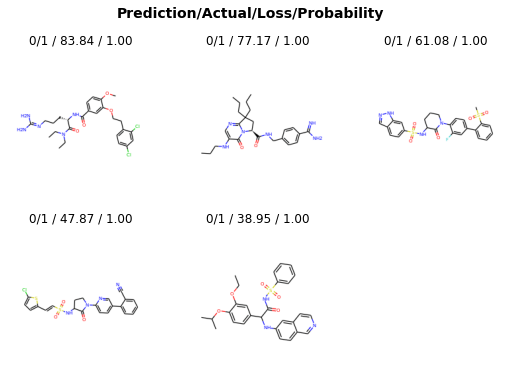

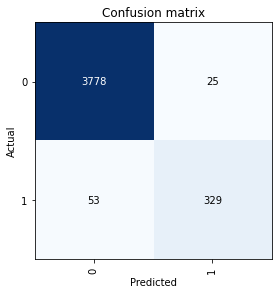

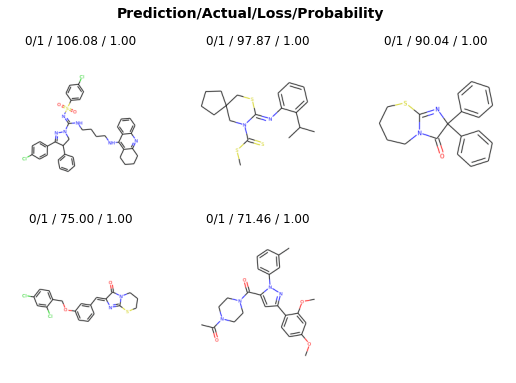

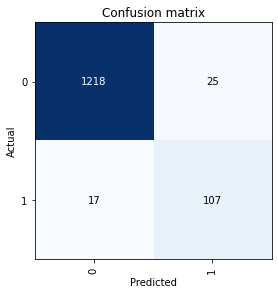

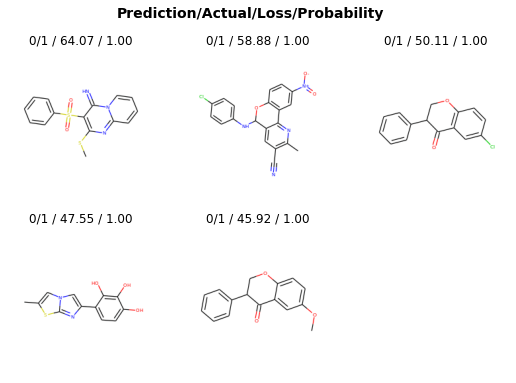

In [49]:
for dataset in datasets: 
    learn = train_on_dataset(dataset)
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
    interp.plot_top_losses(k=5)
    learn.export(fname= f'models/{dataset}.pkl')

# Transfer learning

### Idea: Create a model that performs good on all datasets after a couple of epochs

In [59]:
datasets = ['CHEMBL205',  'CHEMBL301',  
            'CHEMBL240', 'CHEMBL219', 
            'CHEMBL244', 'CHEMBL218',
           'CHEMBL1978',]

In [92]:
learn = train_on_dataset(datasets[0], epochs=5)

Training model on dataset: CHEMBL205
Architechture: <function resnet18 at 0x7f6aef3e3d40>
Trained epochs: epochs=5
Weight decay: wd=None
Finding learning rate...


Training model with learning rate: 0.00831763744354248


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.508482,0.364152,0.902480,0.630802,0.480707,0.917178,0.961326,0.621180,00:32


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.308266,0.139736,0.958763,0.773006,0.773006,0.773006,0.965882,0.750328,00:41
1,0.287860,0.311957,0.901644,0.639428,0.479326,0.960123,0.974766,0.637555,00:41
2,0.190809,0.150745,0.953748,0.781003,0.685185,0.907975,0.979863,0.765076,00:41
3,0.114694,0.126239,0.959320,0.808901,0.705479,0.947853,0.987528,0.797433,00:41
4,0.069320,0.116890,0.968515,0.844138,0.766917,0.938650,0.987443,0.832047,00:41


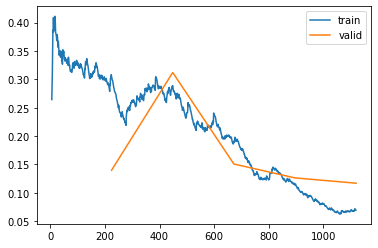

In [93]:
learn.recorder.plot_loss()

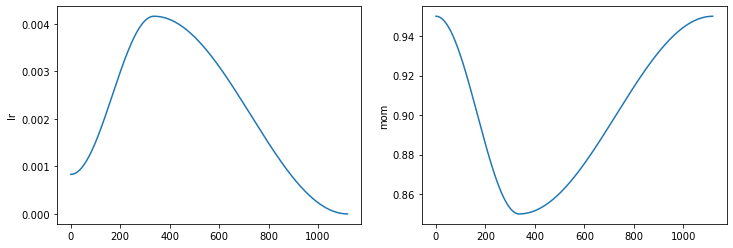

In [94]:
learn.recorder.plot_sched()

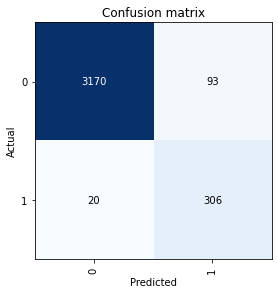

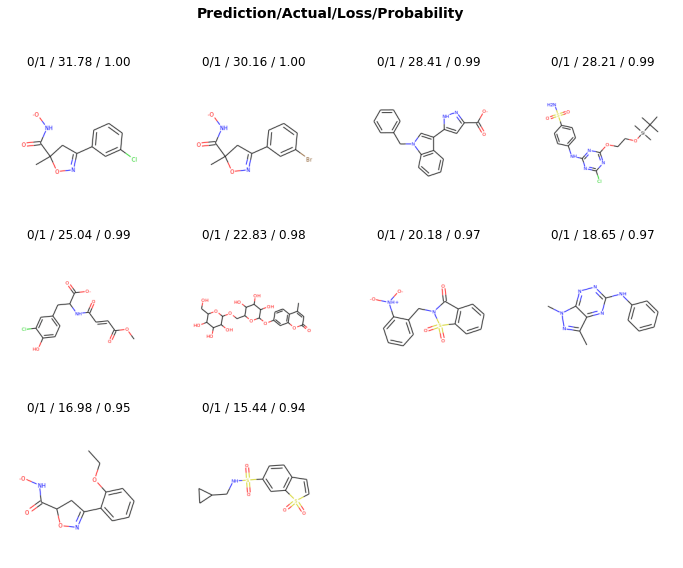

In [95]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

In [101]:
learn = train_on_dataset(datasets[1], learn, epochs=5)

Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.311723,0.362595,0.847195,0.494670,0.353659,0.822695,0.920497,0.473324,00:14


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.307457,0.376523,0.840103,0.491803,0.345821,0.851064,0.921342,0.476031,00:17
1,0.301280,0.389578,0.833011,0.480962,0.335196,0.851064,0.921443,0.465493,00:17
2,0.303013,0.363307,0.847195,0.496815,0.354545,0.829787,0.921196,0.476757,00:18
3,0.300111,0.364379,0.850419,0.502146,0.360000,0.829787,0.921503,0.481935,00:17
4,0.304614,0.358110,0.854288,0.508696,0.366771,0.829787,0.921835,0.488286,00:17


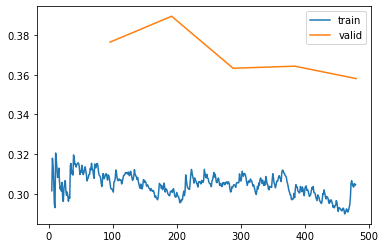

In [102]:
learn.recorder.plot_loss()

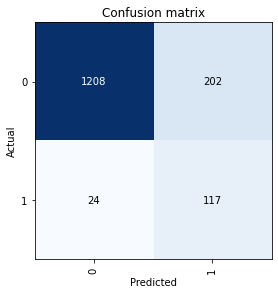

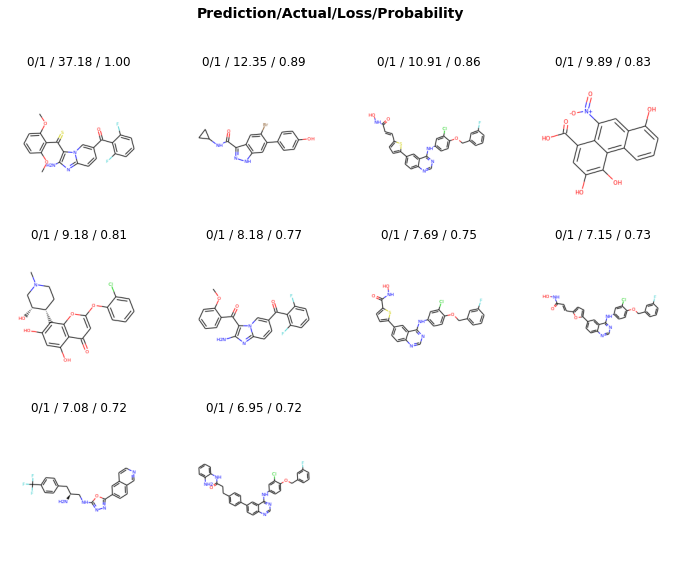

In [103]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

In [117]:
learn=None

In [118]:
for i in range(20):
    for d in datasets:
        learn = train_on_dataset(d, learn=learn, epochs=1)

Training model on dataset: CHEMBL205
Architechture: <function resnet34 at 0x7f6aef3e3dd0>
Trained epochs: epochs=1
Weight decay: wd=None


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/kjetil/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Finding learning rate...


Training model with learning rate: 0.002290867641568184


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.571189,0.432852,0.841739,0.508651,0.354217,0.901840,0.933903,0.502699,00:50


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.246068,0.217650,0.938144,0.737589,0.600000,0.957055,0.980589,0.729322,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.657814,0.492963,0.804642,0.372671,0.263158,0.638298,0.821588,0.318676,00:23


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.426422,0.246227,0.911670,0.647815,0.508065,0.893617,0.964358,0.633059,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.780535,0.479751,0.753896,0.314647,0.210654,0.621429,0.763107,0.252152,00:23


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.482226,0.455379,0.779870,0.406305,0.269142,0.828571,0.882949,0.386502,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.506287,0.531442,0.748653,0.375000,0.242075,0.831683,0.864318,0.354685,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.415569,0.415718,0.823160,0.490956,0.332168,0.940594,0.942138,0.494323,00:21


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.509092,0.368530,0.833929,0.481390,0.336222,0.847162,0.920071,0.465068,00:37


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.230655,0.205150,0.924116,0.700157,0.546569,0.973799,0.988680,0.696788,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.507937,0.463464,0.779928,0.392881,0.262555,0.780105,0.866418,0.362783,01:01


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.229302,0.176328,0.935245,0.724313,0.592346,0.931937,0.985459,0.712443,01:16


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.708845,0.465350,0.770300,0.389105,0.256410,0.806452,0.867419,0.364528,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.270869,0.246783,0.901975,0.639785,0.479839,0.959677,0.973380,0.637862,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.319405,0.234192,0.914739,0.662252,0.517241,0.920245,0.966825,0.651455,00:52


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.212764,0.215630,0.925606,0.704319,0.551127,0.975460,0.982110,0.701054,01:06


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.796425,0.447141,0.789168,0.384181,0.261538,0.723404,0.851954,0.344003,00:23


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.322322,0.293894,0.885235,0.597285,0.438538,0.936170,0.963528,0.593386,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.657356,0.443912,0.770130,0.372340,0.247642,0.750000,0.859286,0.336049,00:23


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.407230,0.347188,0.848701,0.503198,0.358663,0.842857,0.926602,0.485460,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.587443,0.488823,0.782765,0.395000,0.264214,0.782178,0.847742,0.366101,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.415160,0.437915,0.794434,0.445521,0.294872,0.910891,0.922131,0.443590,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.476758,0.364782,0.843862,0.491591,0.349265,0.829694,0.922647,0.471596,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.212435,0.210480,0.935240,0.728785,0.588710,0.956332,0.987117,0.720755,00:45


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.364261,0.274864,0.901075,0.621572,0.477528,0.890052,0.960648,0.607234,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.176433,0.168118,0.941697,0.746362,0.618966,0.939791,0.987365,0.734917,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.652489,0.367998,0.817118,0.449339,0.309091,0.822581,0.899956,0.428949,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.225989,0.230256,0.906364,0.650273,0.491736,0.959677,0.973808,0.647629,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.246529,0.211171,0.932293,0.718424,0.577281,0.950920,0.977650,0.710048,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.154226,0.183682,0.942881,0.755662,0.617934,0.972393,0.984162,0.749058,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.434888,0.248455,0.892328,0.593674,0.451852,0.865248,0.959791,0.576419,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.188605,0.168217,0.935525,0.725275,0.591928,0.936170,0.983064,0.714168,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.749057,0.313408,0.873377,0.459834,0.375566,0.592857,0.865469,0.405310,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.295801,0.283272,0.887662,0.572840,0.437736,0.828571,0.929791,0.550013,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.467959,0.366546,0.848294,0.512968,0.361789,0.881188,0.917967,0.502685,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.320489,0.321949,0.863555,0.558140,0.395062,0.950495,0.953017,0.559957,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.240737,0.207311,0.915773,0.667712,0.520782,0.930131,0.977137,0.658311,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.102916,0.095536,0.967819,0.842718,0.758741,0.947598,0.995024,0.831364,00:45


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.192322,0.146610,0.945520,0.751634,0.643657,0.903141,0.980770,0.735077,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.098315,0.112940,0.958662,0.803185,0.710262,0.924084,0.985947,0.788973,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.500884,0.229716,0.897586,0.619565,0.467213,0.919355,0.959892,0.611077,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.163266,0.159447,0.942941,0.746753,0.625000,0.927419,0.974087,0.733696,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.232987,0.191342,0.935358,0.726415,0.590038,0.944785,0.978292,0.716661,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.134723,0.141268,0.955698,0.798479,0.680346,0.966258,0.986431,0.789487,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.406556,0.177747,0.928433,0.697548,0.566372,0.907801,0.978945,0.683054,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.186080,0.170090,0.932302,0.709141,0.581818,0.907801,0.982979,0.694250,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.460408,0.336046,0.851299,0.515856,0.366366,0.871429,0.922893,0.503287,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.264627,0.237910,0.906493,0.619048,0.491597,0.835714,0.943265,0.595911,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.456640,0.352081,0.842011,0.516484,0.357414,0.930693,0.944504,0.516461,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.246861,0.203476,0.929084,0.704120,0.566265,0.930693,0.972135,0.693126,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.364659,0.196294,0.922130,0.673333,0.544474,0.882096,0.970163,0.655662,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.087631,0.105065,0.968216,0.841897,0.768953,0.930131,0.992721,0.829020,00:45


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.304997,0.204765,0.924970,0.679592,0.556856,0.871728,0.964720,0.660051,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.110436,0.128954,0.952927,0.779888,0.680312,0.913613,0.986853,0.764448,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.290907,0.308445,0.894660,0.621053,0.460938,0.951613,0.961345,0.618806,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.168662,0.138693,0.949525,0.775244,0.650273,0.959677,0.978577,0.765987,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.539603,0.199484,0.918362,0.636025,0.534447,0.785276,0.945947,0.605827,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.193383,0.176723,0.945110,0.756489,0.633540,0.938650,0.979426,0.744723,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.907946,0.372780,0.853643,0.470862,0.350694,0.716312,0.878401,0.431521,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.204745,0.194399,0.927788,0.695652,0.563877,0.907801,0.963236,0.681229,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.419921,0.277276,0.876623,0.538835,0.408088,0.792857,0.923296,0.511001,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.241820,0.178950,0.929870,0.684211,0.579208,0.835714,0.958372,0.659973,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.528023,0.320530,0.877020,0.486891,0.391566,0.643564,0.876712,0.438525,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.406962,0.320143,0.862657,0.508039,0.376190,0.782178,0.913921,0.479282,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.296005,0.192960,0.924116,0.681135,0.551351,0.890830,0.973629,0.664553,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.105076,0.094491,0.969408,0.845691,0.781481,0.921397,0.992057,0.832303,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.182606,0.180297,0.930944,0.703590,0.578415,0.897906,0.975802,0.687243,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.090161,0.093346,0.967503,0.833741,0.782110,0.892670,0.987500,0.818010,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.507958,0.310960,0.873446,0.552972,0.406844,0.862903,0.943295,0.537264,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.103279,0.147587,0.946598,0.766773,0.634921,0.967742,0.982560,0.759010,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.232740,0.170387,0.944553,0.756426,0.629328,0.947853,0.983331,0.745998,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.137088,0.146918,0.955419,0.795918,0.681223,0.957055,0.986035,0.785753,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.673020,0.288567,0.878143,0.551069,0.414286,0.822695,0.933650,0.527968,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.137477,0.150321,0.941973,0.739884,0.624390,0.907801,0.977929,0.724213,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.678551,0.262891,0.909740,0.541254,0.503067,0.585714,0.868408,0.493269,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.296271,0.200165,0.930519,0.664577,0.592179,0.757143,0.923888,0.632356,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.401147,0.266467,0.888689,0.589404,0.442786,0.881188,0.952802,0.575407,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.220988,0.183321,0.934470,0.722433,0.586420,0.940594,0.969906,0.712240,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.164034,0.097840,0.971395,0.848739,0.817814,0.882096,0.981101,0.833695,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.103947,0.091370,0.969011,0.847656,0.766784,0.947598,0.993433,0.836391,00:45


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.324984,0.199849,0.919235,0.675000,0.533435,0.918848,0.974921,0.663112,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.084550,0.101868,0.962724,0.819861,0.733471,0.929319,0.988969,0.806360,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.441204,0.217671,0.911485,0.643068,0.506977,0.879032,0.961767,0.626163,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.086277,0.113385,0.967081,0.837545,0.758170,0.935484,0.981003,0.825057,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.203239,0.192786,0.938980,0.735187,0.606786,0.932515,0.967699,0.723181,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.137914,0.158328,0.947060,0.768856,0.637097,0.969325,0.985404,0.761218,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.573362,0.212899,0.923920,0.664773,0.554502,0.829787,0.944786,0.639910,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.142222,0.123561,0.952289,0.771605,0.683060,0.886525,0.981902,0.753369,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.038619,0.342541,0.893506,0.442177,0.422078,0.464286,0.803168,0.383991,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.578188,0.266274,0.905844,0.511785,0.484076,0.542857,0.873954,0.460796,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.636288,0.275860,0.893178,0.573477,0.449438,0.792079,0.926050,0.544895,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.246295,0.195693,0.920108,0.673993,0.534884,0.910891,0.965635,0.661083,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.208479,0.096606,0.967024,0.836935,0.760714,0.930131,0.991598,0.823920,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.043027,0.050561,0.986492,0.927039,0.911392,0.943231,0.994759,0.919763,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.279590,0.188992,0.929749,0.699387,0.573826,0.895288,0.971711,0.682774,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.077149,0.096505,0.966547,0.833333,0.764192,0.916230,0.989438,0.819055,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.220549,0.179665,0.949525,0.775244,0.650273,0.959677,0.980562,0.765987,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.150093,0.139818,0.949525,0.775244,0.650273,0.959677,0.982872,0.765987,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.378461,0.174705,0.940931,0.734336,0.620763,0.898773,0.972501,0.717591,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.125530,0.151317,0.958763,0.810256,0.696035,0.969325,0.986550,0.801430,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.511148,0.473820,0.865248,0.340694,0.306818,0.382979,0.776802,0.268701,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.409610,0.314222,0.883946,0.554455,0.425856,0.794326,0.915708,0.526487,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.647063,0.259207,0.898701,0.595855,0.467480,0.821429,0.930388,0.571136,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.195129,0.175121,0.942208,0.721003,0.642458,0.821429,0.956556,0.695784,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.574090,0.302245,0.886894,0.519084,0.422360,0.673267,0.898791,0.474817,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.413686,0.301796,0.881508,0.525180,0.412429,0.722772,0.924936,0.487052,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.262735,0.172779,0.934843,0.696296,0.604502,0.820961,0.953757,0.670459,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.105792,0.101310,0.967024,0.833667,0.770370,0.908297,0.984247,0.818910,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.235692,0.176436,0.930705,0.699170,0.579038,0.882199,0.974578,0.680668,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.089266,0.085165,0.973477,0.862112,0.820331,0.908377,0.986668,0.848829,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.189548,0.123034,0.963424,0.821429,0.737179,0.927419,0.979102,0.807906,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.178160,0.277162,0.904901,0.646739,0.487705,0.959677,0.975274,0.644336,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.252963,0.187907,0.942881,0.750305,0.622222,0.944785,0.975996,0.739624,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.180068,0.154432,0.953190,0.789474,0.667373,0.966258,0.984110,0.780707,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.598550,0.386675,0.833656,0.466942,0.329446,0.801418,0.896746,0.442142,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.251062,0.201413,0.916828,0.670077,0.524000,0.929078,0.978688,0.660394,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.832196,0.473126,0.765584,0.340037,0.228501,0.664286,0.799403,0.286859,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.421245,0.361387,0.825325,0.454361,0.317280,0.800000,0.903444,0.429414,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.469989,0.364937,0.835727,0.490251,0.341085,0.871287,0.926178,0.478810,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.328632,0.312532,0.858169,0.543353,0.383673,0.930693,0.966358,0.541844,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.708467,0.429378,0.803735,0.388614,0.271157,0.685590,0.853431,0.342449,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.273554,0.217784,0.925705,0.685714,0.557377,0.890830,0.967451,0.668979,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.531483,0.460863,0.775866,0.418835,0.274351,0.884817,0.904349,0.410579,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.212939,0.235583,0.908722,0.654611,0.500000,0.947644,0.981230,0.649078,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.401004,0.161092,0.940746,0.717770,0.631902,0.830645,0.963642,0.693353,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.125934,0.134458,0.956108,0.795918,0.688235,0.943548,0.977591,0.784072,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.266374,0.187410,0.934522,0.719235,0.589041,0.923313,0.974934,0.706387,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.177849,0.148631,0.951797,0.782936,0.662420,0.957055,0.984922,0.773056,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.639726,0.333209,0.857511,0.512141,0.371795,0.822695,0.929541,0.490302,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.179483,0.160944,0.940683,0.737143,0.617225,0.914894,0.983039,0.722497,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.736685,0.417143,0.790260,0.426288,0.283688,0.857143,0.909117,0.412663,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.284038,0.224817,0.910390,0.629032,0.504310,0.835714,0.947015,0.605626,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.506709,0.391081,0.820467,0.415205,0.294606,0.702970,0.869977,0.373187,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.455436,0.374590,0.834829,0.455621,0.324895,0.762376,0.895048,0.424070,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.418019,0.242514,0.911800,0.627517,0.509537,0.816594,0.955248,0.601318,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.150901,0.113807,0.963846,0.823301,0.741259,0.925764,0.992131,0.809598,00:45


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.322160,0.165074,0.936679,0.711014,0.609346,0.853403,0.975613,0.688680,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.132626,0.112896,0.955317,0.792453,0.687861,0.934555,0.988184,0.779397,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.982481,0.435150,0.794440,0.398287,0.271137,0.750000,0.868009,0.363598,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.152241,0.184450,0.927579,0.704478,0.559242,0.951613,0.975677,0.696986,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.273883,0.181771,0.950125,0.766623,0.666667,0.901840,0.977143,0.749989,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.113610,0.141118,0.956534,0.799486,0.688053,0.953988,0.985207,0.788865,01:05


Training model on dataset: CHEMBL301


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,1.007636,0.382884,0.883301,0.484330,0.404762,0.602837,0.860384,0.432030,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.221907,0.238123,0.906512,0.629156,0.492000,0.872340,0.964363,0.611599,00:28


Training model on dataset: CHEMBL240


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.608297,0.275380,0.889610,0.545455,0.435897,0.728571,0.907413,0.507965,00:22


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.240770,0.205137,0.925325,0.670487,0.559809,0.835714,0.956816,0.646333,00:28


Training model on dataset: CHEMBL219


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.448012,0.361745,0.859066,0.539589,0.383333,0.910891,0.929520,0.534129,00:16


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.295948,0.268762,0.902154,0.635452,0.479798,0.940594,0.966690,0.630091,00:20


Training model on dataset: CHEMBL244


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.786917,0.452137,0.804529,0.327869,0.238569,0.524017,0.771781,0.256472,00:36


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.392521,0.286530,0.884783,0.557927,0.428571,0.799127,0.927091,0.530601,00:46


Training model on dataset: CHEMBL218


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.206778,0.153445,0.941935,0.740662,0.625225,0.908377,0.981096,0.724923,01:00


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.076577,0.080327,0.972043,0.855734,0.808858,0.908377,0.988947,0.842047,01:15


Training model on dataset: CHEMBL1978


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.664453,0.339011,0.861741,0.531017,0.383513,0.862903,0.931831,0.516280,00:20


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.108145,0.123882,0.956840,0.795848,0.696970,0.927419,0.977370,0.782115,00:25


Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.216579,0.166289,0.946503,0.758794,0.642553,0.926380,0.969475,0.745274,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.091210,0.134188,0.960435,0.812665,0.712963,0.944785,0.984413,0.800833,01:05


Training model on dataset: CHEMBL301


TypeError: cannot unpack non-iterable NoneType object

In [119]:
learn = train_on_dataset(datasets[0], learn=learn, epochs=20)

Training model on dataset: CHEMBL205


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.085320,0.132725,0.961271,0.816380,0.716937,0.947853,0.984275,0.804888,00:51


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.079221,0.131259,0.962664,0.821333,0.726415,0.944785,0.984329,0.809513,01:04
1,0.094397,0.116270,0.964614,0.826739,0.744472,0.929448,0.984334,0.813469,01:04
2,0.085856,0.130452,0.962664,0.821333,0.726415,0.944785,0.984376,0.809513,01:05
3,0.084821,0.127135,0.962664,0.819892,0.729665,0.935583,0.984303,0.807110,01:04
4,0.089998,0.132398,0.962385,0.820240,0.724706,0.944785,0.984484,0.808415,01:04
5,0.083510,0.115843,0.965450,0.831063,0.747549,0.935583,0.984436,0.818431,01:04
6,0.088606,0.132993,0.960713,0.813245,0.715618,0.941718,0.984424,0.801072,01:05
7,0.093935,0.123982,0.963221,0.821622,0.734300,0.932515,0.984333,0.808556,01:05
8,0.094564,0.133053,0.962106,0.819629,0.721963,0.947853,0.984660,0.808136,01:05
9,0.103646,0.128221,0.962942,0.821954,0.729216,0.941718,0.984470,0.809815,01:05


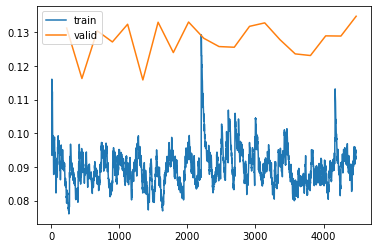

In [120]:
learn.recorder.plot_loss()

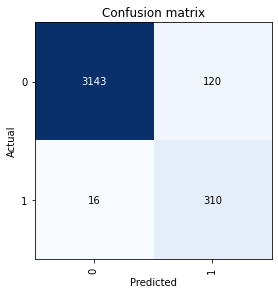

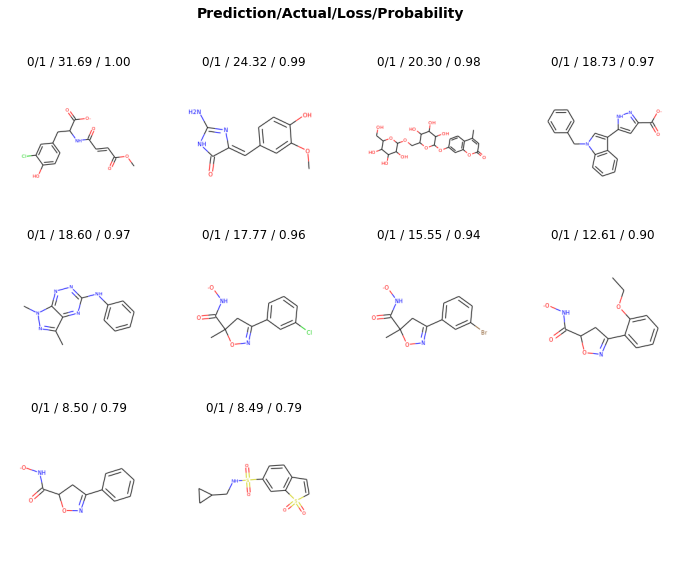

In [121]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

In [113]:
learn.export(fname= f'models/transfer_model.pkl')